<a href="https://colab.research.google.com/github/Rathore25/Reddit-Sentiment-Pre-Post-Covid/blob/main/Train_Sentiment_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import sklearn

In [2]:
features = ['target','ids','date','flag','user','text']
df = pd.read_csv('/content/drive/MyDrive/NEU/6120/Final Project/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", engine='python', names=features)
df = df[['text','target']]
df['target'] = df['target'].replace(4,1)
df.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [3]:
df.shape

(1600000, 2)

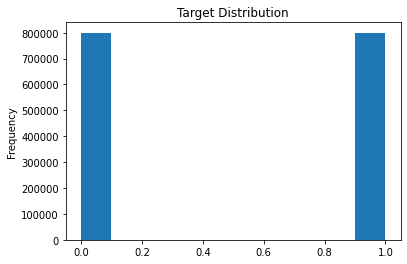

In [4]:
df['target'].plot(kind='hist', title='Target Distribution')

In [5]:
from sklearn.model_selection import train_test_split

#train_df, valid_df = train_test_split(df, random_state=42, train_size=0.8, stratify=df.target.values)

train_df, remaining = train_test_split(df, random_state=42, train_size=0.01, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)

train_df.shape, valid_df.shape

((16000, 2), (1584, 2))

In [6]:
train_df.head()

,text,target
923917,"Ugh studying today, last final tomorrow, then ...",1
107858,Some times the time stops moving it looks like...,0
1161519,lovin this sunshine @boydface was amazingg l...,1
946617,@ch0colatechip yeah we do actually. I been dea...,1
1121400,"reading The Little Prince, thanks Justina",1


In [8]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [9]:
module_url_transformer  = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
module_url_DAN          = "https://tfhub.dev/google/universal-sentence-encoder/4"
output_dir              = "/content/drive/MyDrive/NEU/6120/Final Project/"

In [10]:
!nvidia-smi

Wed Apr 28 21:54:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

     |████████████████████████████████| 1.0MB 18.4MB/s 


In [14]:
histories = {}
models    = {}

In [15]:
def train_and_evaluate_model(module_url, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[512], dtype=tf.string, trainable=trainable)

  model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.losses.BinaryCrossentropy(),
                metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])
  model.summary()

  history = model.fit(train_df['text'], train_df['target'],
                      epochs=100,
                      batch_size=32,
                      validation_data=(valid_df['text'], valid_df['target']),
                      callbacks=[tfdocs.modeling.EpochDots(), 
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')],
                      verbose=0)
  return model, history

In [16]:
models['train_false_16k_transformer'], histories['train_false_16k_transformer'] = train_and_evaluate_model(module_url_transformer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               147354880 
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________

Epoch: 0, accuracy:0.7571,  loss:0.5654,  val_accuracy:0.7879,  val_loss:0.4554,  
..........

In [17]:
models['train_false_16k_DAN'], histories['train_false_16k_DAN'] = train_and_evaluate_model(module_url_DAN)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 256,945,665
Trainable params: 147,841
Non-trainable params: 256,797,824
_________________________________________________________________

Epoch: 0, accuracy:0.7342,  loss:0.5845,  val_accuracy:0.7607,  val_loss:0.4884,  
.............

In [ ]:
models['train_false_16k'], histories['train_false_16k'] = train_and_evaluate_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               147354880 
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________

Epoch: 0, accuracy:0.7500,  loss:0.5758,  val_accuracy:0.7898,  val_loss:0.4588,  
..........

In [ ]:
models['train_true_16k'], histories['train_true_16k'] = train_and_evaluate_model(True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,502,721
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.7990,  loss:0.4461,  val_accuracy:0.8100,  val_loss:0.4269,  
...

In [ ]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.02, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)

train_df.shape, valid_df.shape

((32000, 2), (1568, 2))

In [ ]:
models['train_false_32k'], histories['train_false_32k'] = train_and_evaluate_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________

Epoch: 0, accuracy:0.7729,  loss:0.5051,  val_accuracy:0.8093,  val_loss:0.4197,  
..............

In [ ]:
models['train_true_32k'], histories['train_true_32k'] = train_and_evaluate_model(True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,502,721
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.8099,  loss:0.4235,  val_accuracy:0.8399,  val_loss:0.3590,  
...

In [18]:
for name, model in models.items():
  model.save(output_dir+name)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NEU/6120/Final Project/train_false_16k_transformer/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NEU/6120/Final Project/train_false_16k_transformer/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NEU/6120/Final Project/train_false_16k_DAN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NEU/6120/Final Project/train_false_16k_DAN/assets


In [19]:
import json

for name, history in histories.items():
  json.dump(history.history, open(output_dir+name+'_history.json', 'w'))

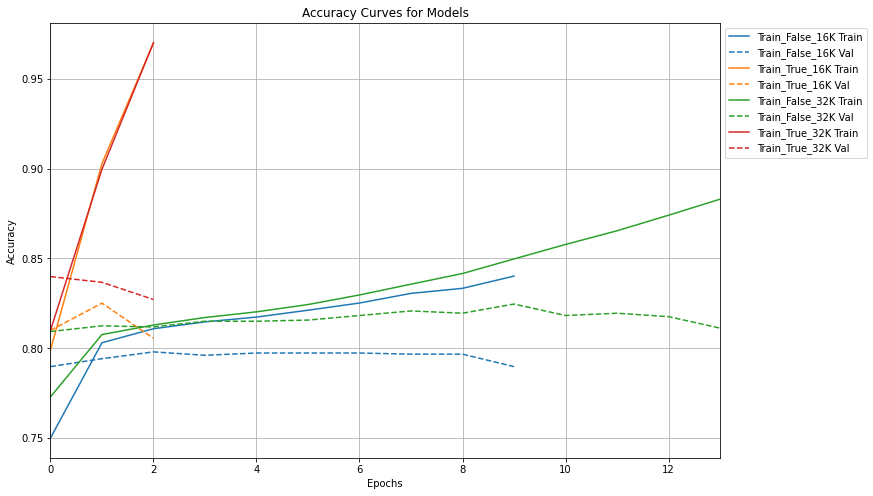

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

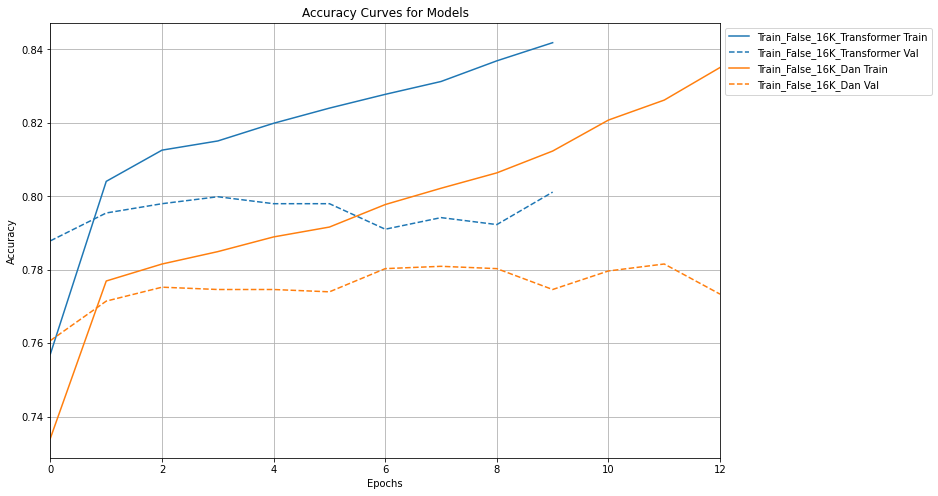

In [20]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

In [21]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.01, stratify=df.target.values)
valid_df, remaining = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)
test_df, _ = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)

In [22]:
model_transformer = models['train_false_16k_transformer']
model_DAN         = models['train_false_16k_DAN']

In [32]:
pred_y  = model_DAN.predict_classes(test_df['text'])
pred_y  = np.squeeze(pred_y)
acc_DAN = sklearn.metrics.accuracy_score(list(test_df['target'].values), pred_y)
print("Test accuracy of model based on DAN: ", acc_DAN)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy of model based on DAN:  0.7926675094816688


In [33]:
pred_y    = model_transformer.predict_classes(test_df['text'])
pred_y    = np.squeeze(pred_y)
acc_Trans = sklearn.metrics.accuracy_score(list(test_df['target'].values), pred_y)
print("Test accuracy of model based on Transformer: ", acc_Trans)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy of model based on Transformer:  0.8084702907711757
